In [43]:
import os  # Standard Python module to interact with the operating system (e.g., env variables, file paths)

from openai import OpenAI  # Official OpenAI client – used for making API calls to GPT-4, GPT-3.5, etc.

from langgraph.graph import StateGraph, END  
# LangGraph is used to define stateful graphs (multi-agent or workflow pipelines)
# StateGraph defines nodes and transitions, END is used to mark terminal states

from typing import TypedDict, Annotated  
# Built-in Python module for type hints
# TypedDict helps define structured dictionary types
# Annotated lets you attach metadata to types (useful in LangChain input/output schemas)

import operator  
# Built-in Python module providing functional equivalents of operators (like <, ==, etc.)

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
# These are message types in LangChain's core message passing system
# Used for defining and processing chat-style inputs/outputs

from langchain_openai import ChatOpenAI  
# LangChain wrapper for OpenAI's chat models – lets you call GPT-4/3.5 with extra features like streaming

from langchain_community.tools.tavily_search import TavilySearchResults  
# Community-contributed LangChain integration for Tavily (a web search tool for real-time search results)

from langchain_openai import ChatOpenAI

In [44]:
from dotenv import load_dotenv
load_dotenv()

token = os.getenv("GITHUB_TOKEN")
tavily_api_key = os.getenv("TAVILY_API_KEY")
endpoint = "https://models.github.ai/inference"
model_name = "openai/gpt-4.1-mini"

In [45]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [46]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system  # Optional system prompt to guide LLM behavior

        # Initialize the state graph with custom state type
        graph = StateGraph(AgentState)

        # Node 1: Call the LLM (e.g., GPT-4)
        graph.add_node("llm", self.call_openai)

        # Node 2: Perform the tool actions the LLM requests
        graph.add_node("action", self.take_action)

        # Decide where to go next after calling the LLM:
        # If LLM wants to use a tool → go to "action"
        # Else → end the graph
        graph.add_conditional_edges(
            "llm", self.exists_action,  
            {True: "action", False: END},
        )

        # After taking an action, go back to the LLM
        graph.add_edge("action", "llm")

        # Define starting point of the graph
        graph.set_entry_point("llm")

        # Compile the graph so it's ready to run
        self.graph = graph.compile()

        # Store the tools in a dictionary keyed by tool name
        self.tools = {t.name: t for t in tools}

        # Bind tools to the model (LangChain LLM)
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        # Get the message history from the current state
        messages = state['messages']

        # If a system prompt is set, prepend it to messages
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages

        # Call the LLM with the messages
        message = self.model.invoke(messages)

        # Return the LLM response wrapped in a dict
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        # Get the tool calls from the last message
        tool_calls = state['messages'][-1].tool_calls

        results = []
        for t in tool_calls:
            print(f"Calling: {t}")

            # Check if the tool name returned by LLM is valid
            if t['name'] not in self.tools:
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # Signal for retry
            else:
                # Call the tool with arguments
                result = self.tools[t['name']].invoke(t['args'])

            # Package the tool result as a ToolMessage
            results.append(ToolMessage(
                tool_call_id=t['id'],
                name=t['name'],
                content=str(result)
            ))

        print("Back to the model!")

        # Return tool results to LLM
        return {'messages': results}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

In [47]:
# System prompt
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

# Final fix - correct way to init model
model = ChatOpenAI(
    model="openai/gpt-4.1-mini",
    base_url="https://models.github.ai/inference",
    api_key=token,
)

# Define tool
tool = TavilySearchResults(api_key=tavily_api_key)

# Build agent
abot = Agent(model, [tool], system=prompt)

In [48]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(graph):
    G = nx.DiGraph()

    # Add nodes
    for node_id, node in graph.nodes.items():
        G.add_node(node_id)

    # Add edges
    for edge in graph.edges:
        label = str(edge.data) if edge.conditional else ""
        G.add_edge(edge.source, edge.target, label=label)

    # Layout
    pos = nx.spring_layout(G, seed=42)
    edge_labels = nx.get_edge_attributes(G, 'label')

    # Draw graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.title("LangGraph Visualization (No pygraphviz 😎)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

C:\Users\Shantanu Khosla\AppData\Local\Temp\ipykernel_25208\507448296.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


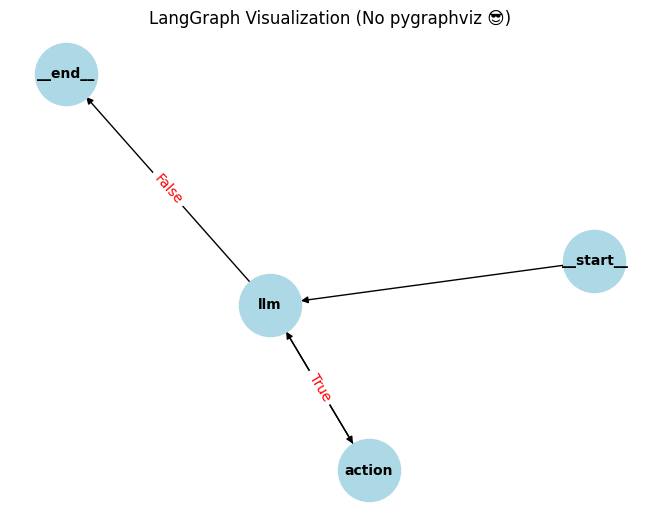

In [49]:
visualize_graph(abot.graph.get_graph())


In [52]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_QOye6wBtQkB0AnpH5HtigLpu', 'type': 'tool_call'}
Back to the model!


In [54]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 57°F. It feels like 56°F and is cool. A light jacket is recommended.'

In [55]:
messages = [HumanMessage(content="What is the weather in SF, LA and NYC?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_fPINAlqUz99m4dm2RWvHbc3M', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_jUjQkl7wUWTSQ9WErjZCJYNL', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in New York City'}, 'id': 'call_Qu3SszXdH48yJcESXv70DTRs', 'type': 'tool_call'}
Back to the model!


In [56]:
result['messages'][-1].content

'The current weather in these cities is as follows:\n\n- San Francisco: 57°F, partly cloudy, cool with a real feel of 56°F.\n- Los Angeles: Sunny with a high of 81°F and a low of 63°F, clear skies.\n- New York City: 81°F, cloudy with a real feel of 84°F, very warm.\n\nWould you like more detailed forecasts for any of these cities?'

In [58]:
query="""
You're an AI compliance strategist for a global LLM company. Based on recent amendments to the EU AI Act (2024) and the US Executive Order on Safe, Secure, and Trustworthy AI, draft a 3-month roadmap detailing specific compliance milestones across three regulatory domains: transparency, data provenance, and risk classification for foundation models.

Your roadmap must be actionable and mapped to engineering, legal, and product stakeholders. Use evidence from the latest policy updates, cite reliable sources if available, and identify one emerging regulation outside the US/EU (e.g., India, Singapore) that companies should monitor.

Avoid generic recommendations—give concrete next steps like "implement model card V2 with synthetic output scoring metrics by Week 6".

Include a risk assessment matrix at the end.

"""
messages = [HumanMessage(content=query)]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 EU AI Act amendments transparency data provenance risk classification'}, 'id': 'call_SgzQCzkR9E4W4buPyRyMohQ4', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 US Executive Order on Safe Secure Trustworthy AI compliance requirements'}, 'id': 'call_PJcGRNrnr8VFNjqXX1mj56gE', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'emerging AI regulations India Singapore 2024'}, 'id': 'call_UmCt2z2eUkLPoWPmP884YzQm', 'type': 'tool_call'}
Back to the model!


In [59]:
result['messages'][-1].content

'Based on the latest amendments to the EU AI Act (2024), the US Executive Order on Safe, Secure, and Trustworthy AI, and emerging regulatory trends in India and Singapore, here is a 3-month compliance roadmap for foundation model deployment, addressing transparency, data provenance, and risk classification. The roadmap includes specific milestones for engineering, legal, and product teams, with referenced evidence and a risk assessment matrix.\n\n---\n\n### 3-Month Roadmap for Compliance (Transparency, Data Provenance, Risk Classification)\n\n#### Month 1: Foundations and Gap Analysis\n- **Engineering**:\n  - Implement detailed audit trails for data ingestion covering origin verification and processing steps per EU AI Act Recital 72 emphasis on transparency and data documentation [EUR-Lex: 2024/1689].\n  - Initiate development of Model Card V2 drafts that incorporate synthetic output scoring metrics for transparency as specified in US EO and EU high-risk system disclosure mandates.\n- 